<a href="https://colab.research.google.com/github/CyberIngeniero/Proyecto_Clustering_HDI/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\color{forestgreen}{\underline{\text{Proyecto Nuevos Clusters para Vehículos}}}$

# Librerias

In [1]:
# Librerias
import os
import shutil

from google.colab import files    #files.upload()
from google.colab import drive    #drive.mount('/gdrive')
#4/4AGCEMTmC7LTpxz0HV4zlzCwBj5gPNTPlTFtZKlVPPCC29XNqVKispg

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from IPython.display import display, Markdown

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Carga y Lectura de Registros

In [2]:
# Se crea directorio de trabajo
path = "/tmp/data_clusters"
os.mkdir(path)

In [3]:
# Montando Drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
# Copia del archivo a directorio local
!cp  /gdrive/My\ Drive/Proyecto_Nuevos_Clusters/Clustering_16_09_2020.csv /tmp/data_clusters

In [5]:
# Moviendo datos a entorno de trabajo
os.rename("/tmp/data_clusters/Clustering_16_09_2020.csv", "/tmp/data_clusters/Base_Clusters_MM.csv")

In [6]:
# Cambiando a directorio de trabajo
os.chdir(path)
print(os.getcwd())

/tmp/data_clusters


In [7]:
df = pd.read_csv("Base_Clusters_MM.csv", delimiter = ';', decimal=",")
df.columns = df.columns.str.lower()
df = df.rename(columns = {'sum([cantidad convertida final])':'cantidad_polizas',
                          'edad_final':'edad'})
df = df.drop(['edad_asegurado'], axis = 1) #version de edad asegurado en el cual se tiene junto extranjero a los 35 años

In [8]:
df.head()

,antiguedad_veh,prima_neta_deducible_anualizada,sisgen_usar,mod_tasacion_fiscal,precot_veh_modelo_id,canal_producto,precot_veh_tipo_id,precot_veh_tipo,precot_veh_uso,precot_veh_uso_id,numero_semana,edad,cotizacion,cantidad_polizas,week enddate,rc_ltv_precot,santander
0,0,0.20,0.85,10.0,260013,DEALERS,1,AUTOMOVIL,Particular (Vehículos de uso personal y/o fami...,1,4.0,65,1,0,27-01-2019,78.9000,0.0
1,0,1.34,0.85,NaN,521022,DIRECTO,6,STATION WAGON,Particular (Vehículos de uso personal y/o fami...,1,3.0,27,1,0,14-04-2019,12.4000,0.0
2,0,1.52,0.85,NaN,521022,DIRECTO,6,STATION WAGON,Particular (Vehículos de uso personal y/o fami...,1,2.0,58,1,1,07-04-2019,7.9210,0.0
3,0,3.52,0.85,4.0,1104021,CORREDOR,6,STATION WAGON,Particular (Vehículos de uso personal y/o fami...,1,4.0,47,1,0,22-03-2020,0.7446,0.0
4,0,3.66,0.85,4.0,1104021,DIRECTO,6,STATION WAGON,Particular (Vehículos de uso personal y/o fami...,1,5.0,Extranjero,1,0,31-05-2020,0.8749,0.0


# Data Treatment

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900452 entries, 0 to 900451
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   antiguedad_veh                   900452 non-null  int64  
 1   prima_neta_deducible_anualizada  900444 non-null  float64
 2   sisgen_usar                      900452 non-null  float64
 3   mod_tasacion_fiscal              896293 non-null  float64
 4   precot_veh_modelo_id             900452 non-null  int64  
 5   canal_producto                   900452 non-null  object 
 6   precot_veh_tipo_id               900452 non-null  int64  
 7   precot_veh_tipo                  900452 non-null  object 
 8   precot_veh_uso                   900452 non-null  object 
 9   precot_veh_uso_id                900452 non-null  int64  
 10  numero_semana                    870210 non-null  float64
 11  edad                             900452 non-null  object 
 12  co

In [20]:
# Ajuste de varibale prima_neta_deducible_anualizada
df['prima_neta_deducible_anualizada'].replace(',','.', inplace=True)
df['prima_neta_deducible_anualizada'] = pd.to_numeric(df['prima_neta_deducible_anualizada'], errors='coerce')

# Ajuste de varibale rc_ltv_precot
df['rc_ltv_precot'].replace(',','.', inplace=True)
df['rc_ltv_precot'] = pd.to_numeric(df['rc_ltv_precot'], errors='coerce')

# Ajuste de varibale precot_veh_modelo_id
df['precot_veh_modelo_id'] = df['precot_veh_modelo_id'].astype('object')

# Ajuste de varibale santander
df['santander'] = df['santander'].astype('object')

# Ajuste de varibale numero_semana
df['numero_semana'] = df['numero_semana'].fillna(value = '0')
# df['numero_semana'] = np.where(df['numero_semana'] == '-', '0', df['numero_semana'])
df['numero_semana'] = df['numero_semana'].astype('int32')

# Ajuste de varibale tasacion fiscal
df['mod_tasacion_fiscal'] = df['mod_tasacion_fiscal'].fillna(value = '11')
#df['mod_tasacion_fiscal'] = np.where(df['mod_tasacion_fiscal'] == '-', '11', df['mod_tasacion_fiscal'])
df['mod_tasacion_fiscal'] = df['mod_tasacion_fiscal'].astype('int32')

# Ajuste de Variable Edad
df['edad'] = np.where(df['edad'] == 'Empresa', '-1', df['edad'])
df['edad'] = np.where(df['edad'] == 'Extranjero', '-2', df['edad'])
df['edad'] = df['edad'].fillna(value = 37)
#df['edad'] = np.where(df['edad'] == '-', '-3',df['edad'] )  #'35' --> Lo cambie para dejarlo no definido
df['edad'] = df['edad'].astype('int32')

# Ajuste de Variable antiguedad_veh
df['antiguedad_veh'] = df['antiguedad_veh'].astype('int32')

# Ajuste de varibale precot_veh_modelo_id
df['precot_veh_uso'].replace({'Particular (Vehículos de uso personal y/o familiar destinado al transporte sin fines de lucro)' : 'Particular', 
                              'Otros usos comerciales distintos de transporte de pasajero y/o carga' : 'Otros Usos', 
                              'Transporte Pasajeros' : 'Transporte',
                              'Taxi Básico' : 'Taxi',
                              'Vehículo de Reparto' : 'Reparto'}, inplace=True)

In [21]:
df.describe()

,antiguedad_veh,prima_neta_deducible_anualizada,sisgen_usar,mod_tasacion_fiscal,precot_veh_tipo_id,precot_veh_uso_id,numero_semana,edad,cotizacion,cantidad_polizas,rc_ltv_precot
count,900452.000000,900444.000000,900452.000000,900452.000000,900452.000000,900452.000000,900452.000000,900452.000000,900452.000000,900452.000000,900443.000000
mean,3.050173,26.472351,0.896108,12.323881,2.016217,2.047468,3.221966,42.022618,1.077146,0.097390,0.871509
std,3.364619,12.885188,0.108102,6.553570,1.951767,9.969696,1.427333,15.918816,0.467091,0.343558,0.164211
min,0.000000,0.200000,0.850000,2.000000,1.000000,1.000000,0.000000,-2.000000,1.000000,0.000000,0.276100
25%,0.000000,18.780000,0.850000,8.000000,1.000000,1.000000,2.000000,32.000000,1.000000,0.000000,0.799700
50%,2.000000,23.700000,0.850000,11.000000,1.000000,1.000000,3.000000,42.000000,1.000000,0.000000,0.888500
75%,5.000000,30.210000,0.890000,16.000000,1.000000,1.000000,4.000000,54.000000,1.000000,0.000000,0.943700
max,19.000000,424.600000,1.500000,111.000000,11.000000,99.000000,6.000000,86.000000,45.000000,23.000000,78.900000


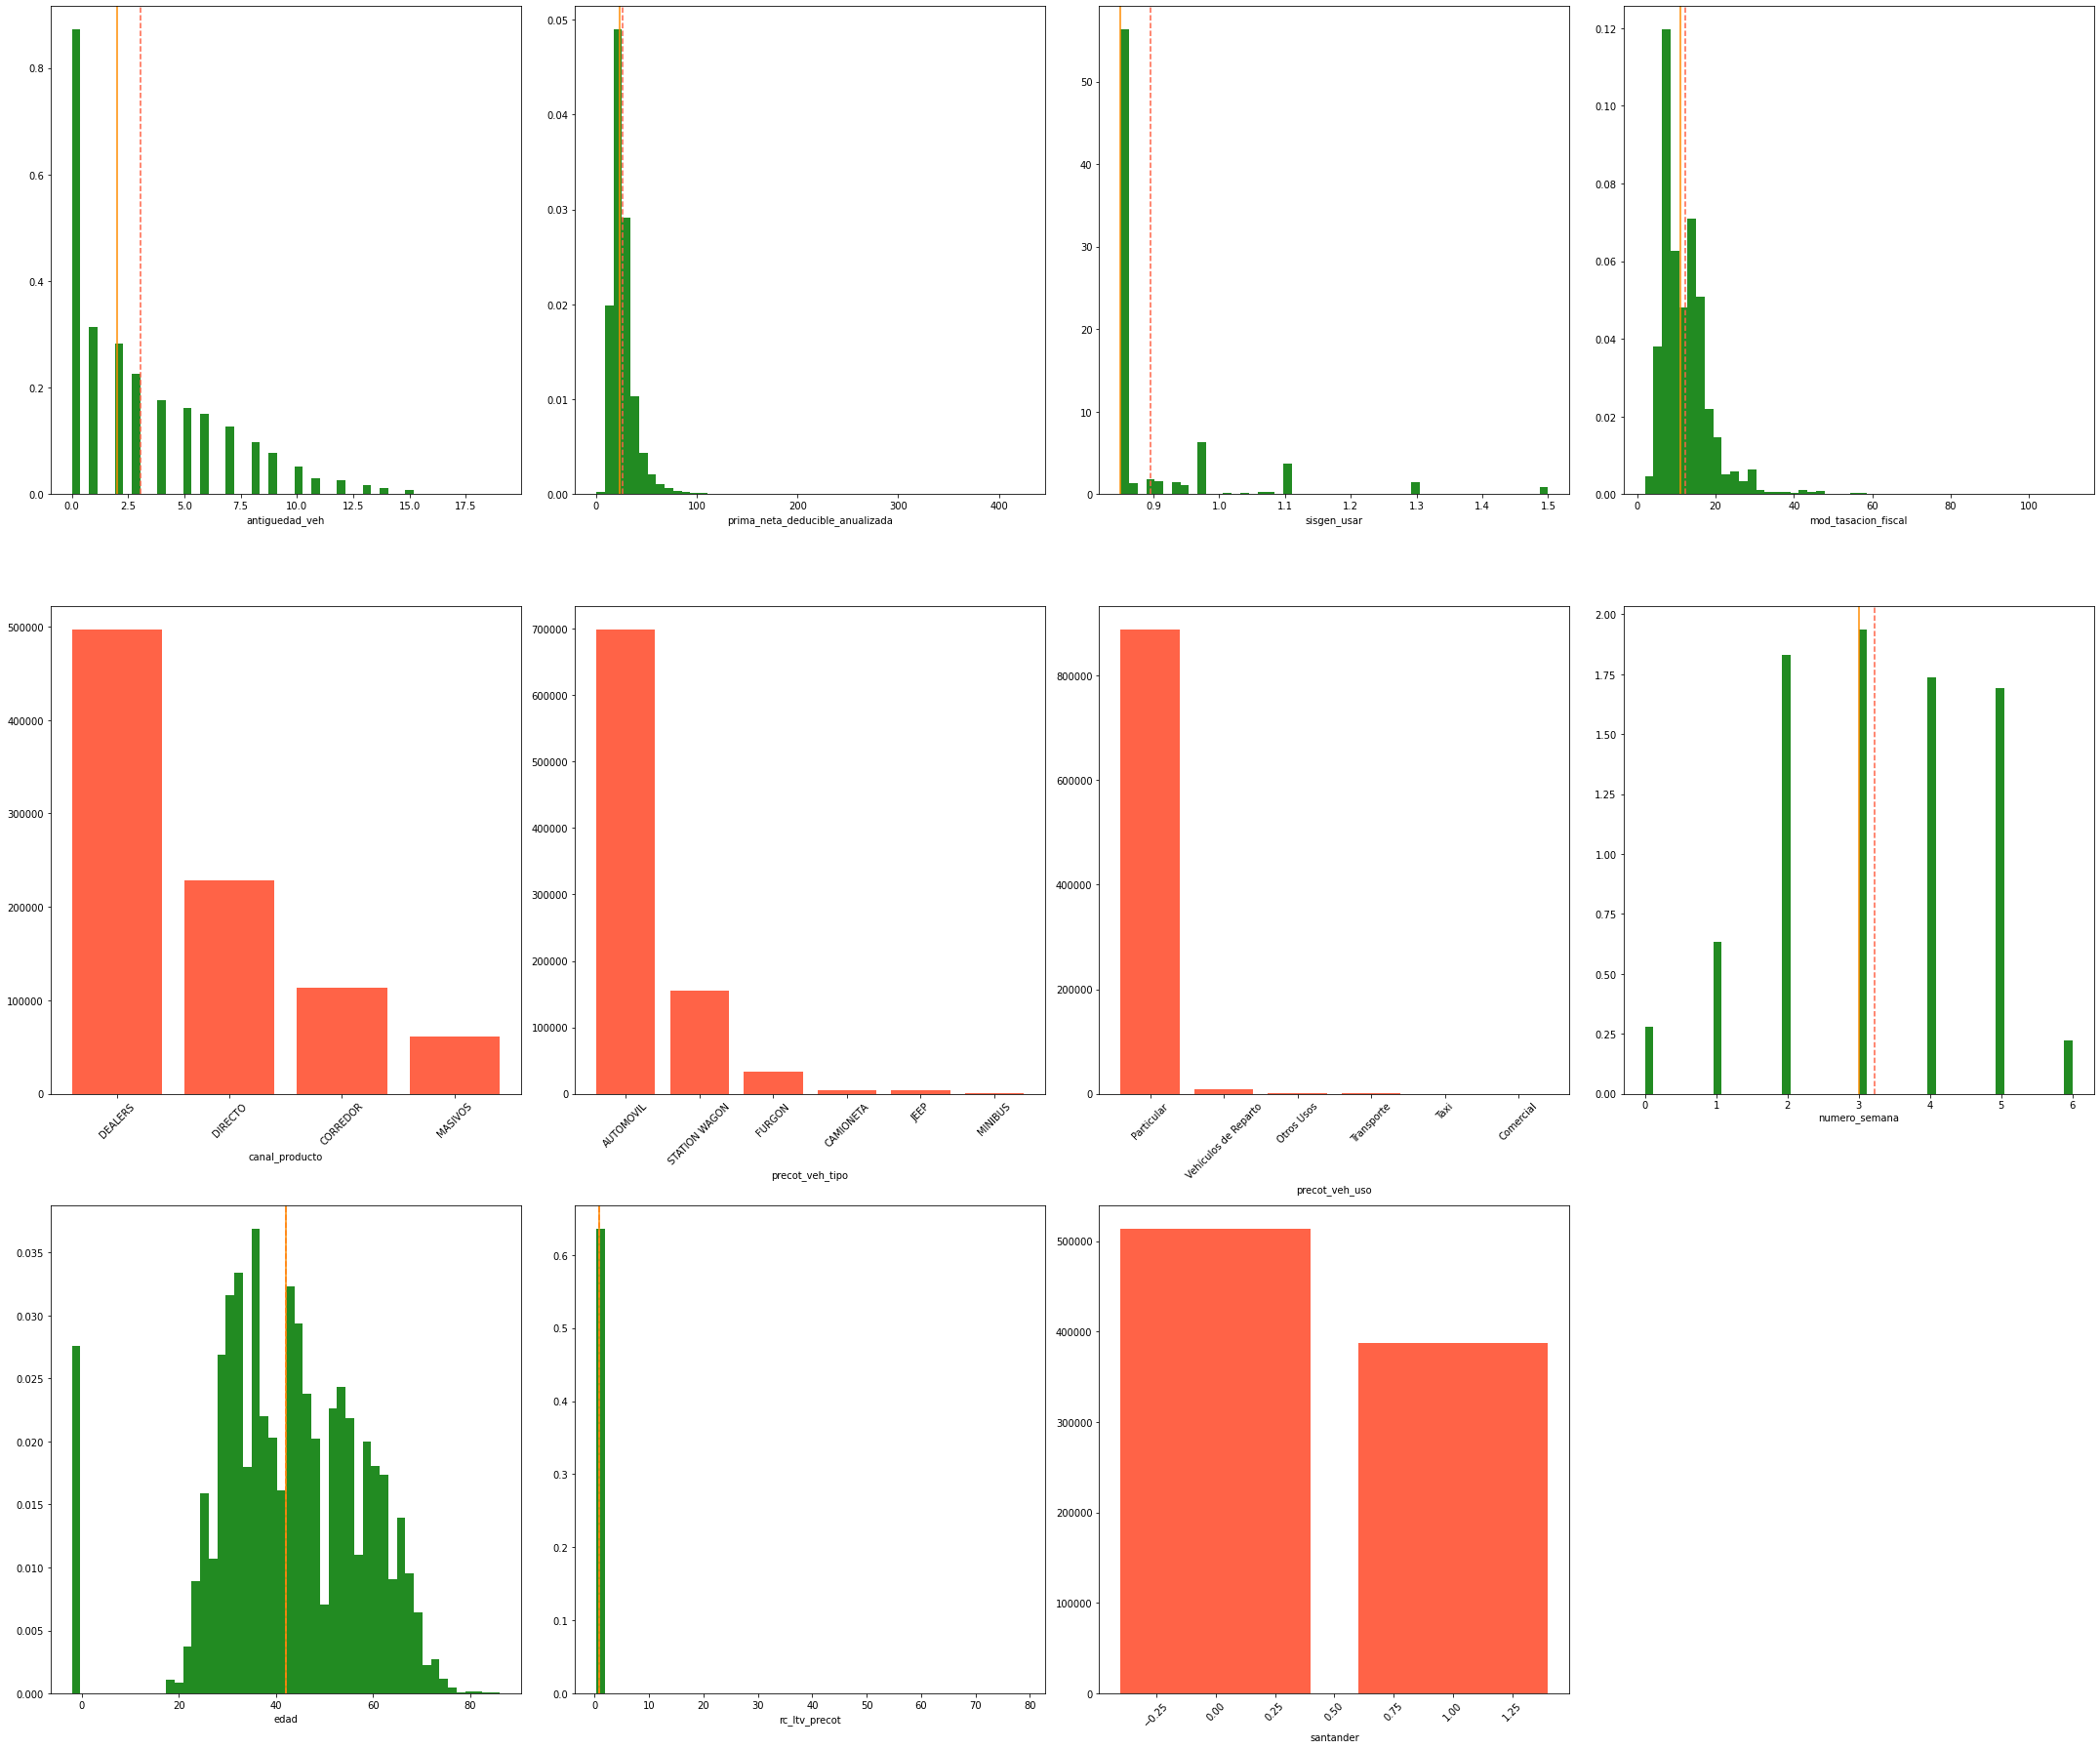

In [22]:
# Analisis Univariado

variables = ['antiguedad_veh', 'prima_neta_deducible_anualizada', 'sisgen_usar',
             'mod_tasacion_fiscal', 'canal_producto', 'precot_veh_tipo', 
             'precot_veh_uso', 'numero_semana', 'edad', 'rc_ltv_precot', 'santander']

i = 0
m = 0

fig, axs = plt.subplots(3, 4, constrained_layout=True, figsize = (30,25))

for var in variables:
    if df[var].dtype == 'O':
        axs[m,i].bar(df[var].unique(), df[var].value_counts(), color='tomato')
        #axs[m,i].set_title(var)
        axs[m,i].set_xlabel(var);
        plt.setp(axs[m,i].xaxis.get_majorticklabels(), rotation=45)

        i += 1

        if i % 4 == 0:
            m += 1
            i = 0
    else:
        axs[m,i].hist(df[var], density=True, color="forestgreen", bins=50)
        axs[m,i].axvline(df[var].mean(), color='tomato', linestyle='--', label='mean')
        axs[m,i].axvline(df[var].median(), color='darkorange', linestyle='-', label='median')
        #axs[m,i].set_xlim([df[var].min() - 1, df[var].max() + 1])
        #axs[m,i-1].set_title(var)
        axs[m,i].set_xlabel(var);
        plt.xticks(rotation=45)

        i += 1

        if i % 4 == 0:
            m += 1
            i = 0

axs[2, 3].remove()             

fig.tight_layout()
plt.show();  

__Comentarios:__

- Se sugiere agrupar antiguedad de vehiculo existente para GLM: [0, 1-2, 3-4, 5-6, 7-8, 8+]
- Se sugiere agrupar la edad

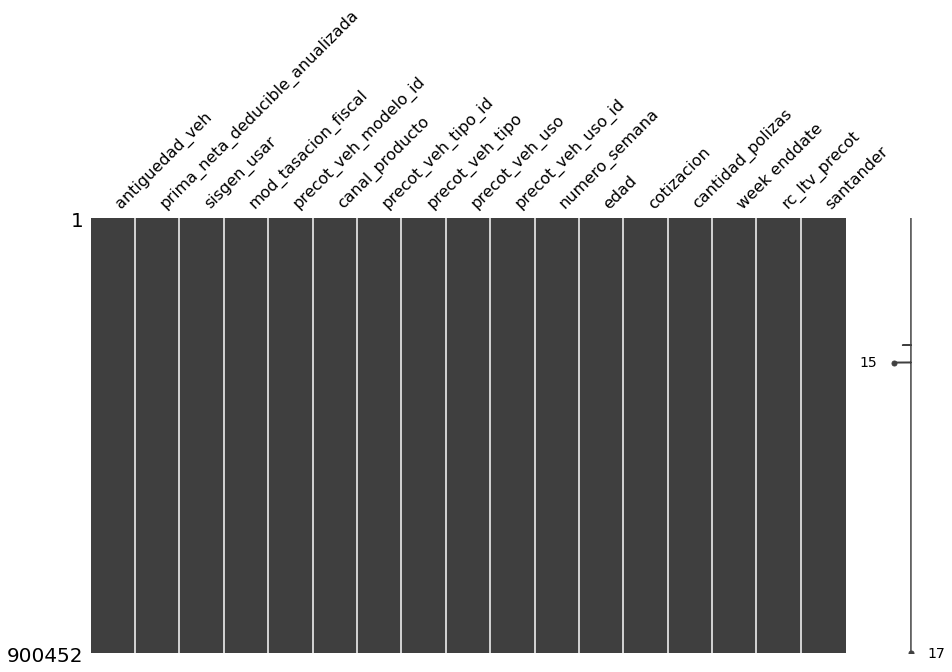

In [15]:
# Analisis de Datos Perdidos
msno.matrix(df, figsize=(15,8));

__COMENTARIOS__
 - Para favorecer el análsis, Los registros na's han sido reemplazados de la siguiente forma:
   - Variable numero_semana: value = '0'
   - Variable mod_tasacion_fiscal: value = '11'
   - Variable edad: value = '37'
